## Implementación de GridWorld

In [103]:
import random

default_board = [
  [' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
  [' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
  [' ','*','*','*','*',' ','*','*','*',' '],
  [' ',' ',' ',' ','*',' ',' ',' ',' ',' '],
  [' ',' ',' ',' ','*','-1',' ',' ',' ',' '],
  [' ',' ',' ',' ','*','1',' ',' ',' ',' '],
  [' ',' ',' ',' ','*',' ',' ',' ',' ',' '],
  [' ',' ',' ',' ','*','-1','-1',' ',' ',' '],
  [' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
  [' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
]

class GridWorld:
  def __init__(self, board=None):
    self.board = board or default_board
    self.dimensions = (len(self.board),len(self.board[0]))
    self.current_state = (0,0)
    self.actions = ['F','↑','↓','←','→']
    self.terminal_actions = ['F']

  def get_current_state(self):
    return self.current_state

  def get_posible_actions(self, coordinates):
    # If the agent is in the border then it can't move out of the board
    # The agent can't move to a cell that has an obstacle
    max_row, max_column = self.dimensions
    lower_row = 0
    upper_row = max_row - 1
    leftmost_col = 0
    rightmost_col = max_column - 1

    if coordinates=='finished':
      return None
    
    curr_row, curr_col = coordinates

    possible_actions = []


    if self.is_terminal(coordinates):
      # If it is a terminal state then return the finish action
      return ['F']
    if curr_row > lower_row:
      possible_actions.append('↑')
    if curr_row < upper_row:
      possible_actions.append('↓')
    if curr_col > leftmost_col:
      possible_actions.append('←')
    if curr_col < rightmost_col:
      possible_actions.append('→')

    return possible_actions
  
  def get_start_state(self):
    return (0,0)
  
  def is_valid_action(self, prev_state, state):
    return  not (state[0] < 0 or state[1] < 0 or  self.board[state[0]][state[1]] == '*')

  def get_reward(self, prev_state, new_state, action):
    return int(self.board[prev_state[0]][prev_state[1]])

  def do_action(self, action):
    curr_row, curr_col = self.get_current_state()
    new_position = None

    # Get the new position
    if action == 'F':
      new_position = (curr_row, curr_col)
    elif action == '↑':
       new_position = (curr_row-1, curr_col)
    elif action == '↓':
      new_position = (curr_row+1, curr_col)
    elif action == '←':
      new_position = (curr_row, curr_col-1)
    elif action == '→':
      new_position = (curr_row, curr_col+1)

    # Check if the new position is valid
    try:
      if not self.is_valid_action((curr_row, curr_col),new_position):
        new_position = (curr_row, curr_col)
    except:
      new_position = (curr_row, curr_col)

    # Calculate the reward as the current state reward
    try:
      reward = self.get_reward((curr_row, curr_col),new_position,action)
    except:
      reward = 0

    # When the finish action was send set the state of the game as finished
    try:
      if self.is_terminal(new_position) and action in self.terminal_actions:
        new_position = 'finished'
    except:
      print('error pos', new_position)

    self.current_state = new_position
    return (reward, new_position)

  def set_current_state(self, new_state):
    row, column = new_state
    self.current_state = (row, column)

  def is_game_over(self, state):
    return state == 'finished'

  def reset(self):
    new_state = None
    while True:
      row = random.randint(0, self.dimensions[0] -1)
      col = random.randint(0, self.dimensions[1] -1)
      if self.board[row][col] != '*':
        self.current_state = (row,col)
        return (row,col)
    

  def is_terminal(self, state):
    curr_row, curr_col = state
    return self.board[curr_row][curr_col] == '1'

## Implementación de la clase Q_Learning

In [104]:
import random
import matplotlib.pyplot as plt
import copy

class Q_Learning():
  def __init__(self, env, discount=0.9, epsilon=0.1, alpha=0.25):
    self.env = env()
    self.discount = discount
    self.epsilon = epsilon
    self.alpha = alpha
    # Matrix to save the value of the state-action pair
    self.Q = {}

  def get_action(self, state):
    return self.calculate_best_action(state)

  # An e-policy that takes the greedy action with 1-e probability and random otherwise
  def choose_action(self, state, random_act = False):
    # Check the possible actions
    possibilities = self.env.get_posible_actions(state)
    # If there are no actions for the state return None
    if not possibilities:
      return None
    # Take a random action with epsilon probability
    if random.random() < self.epsilon or random_act:
      return random.choice(possibilities)
    # Take the greedy action
    return self.calculate_best_action(state)

  # Simulates an episode
  def take_a_step(self):
    curr_state=self.env.get_current_state()
    # Reset the game when the agent reaches the end
    if self.env.is_game_over(curr_state):
      self.env.reset()
      curr_state=self.env.get_current_state()
    # Get the next action
    next_action = None
    while not next_action:
      next_action = self.choose_action(curr_state)
    # Execute the action
    reward, new_position = self.env.do_action(next_action)
    return (curr_state, next_action, reward, new_position)

  def get_value(self, state, action):
    if self.env.is_game_over(state):
      return 0
    return self.Q.get((state,action),0)

  # For a given state choose the action with higher current q value
  def calculate_best_action(self, state):
    best_actions = []
    new_policy = None
    maxVal =  float('-inf')
    possibilities = self.env.get_posible_actions(state)
    if not possibilities:
      return None
    
    for action in possibilities:
      val = self.get_value(state, action)
      # Update the max possible q value
      if val > maxVal:
        maxVal = val
        best_actions = [action]
      elif val == maxVal:
        best_actions.append(action)

    # Break ties randomly
    new_policy = random.choice(best_actions)
    return new_policy
  
  def action_function(self, state, action, reward, new_state):
    curr_value = self.get_value(state, action)
    new_state_action = self.get_action(new_state) # Best action for the state
    next_value = self.get_value(new_state, new_state_action)
    self.Q[(state,action)] = (1-self.alpha)*curr_value + self.alpha*(reward + self.discount*next_value)

  # Simulates an episode, calculates the expected value for every state-action pair, and improves the policy
  def run_an_step(self, logs=False):
    step = self.take_a_step()
    if logs:
      print('step:',step)

    state, action, reward, new_state = step
    # Update the estimate of the state value
    self.action_function(state, action, reward, new_state)

  # Utility function to plot the Q values and the policy
  def show_values_on_the_board(self):
    state_values = copy.deepcopy(self.env.board)
    for row in range(len(state_values)):
      for column in range(len(state_values[row])):
        state_values[row][column] = self.get_value((row, column), self.get_action((row, column)))
    return state_values

  # Plots the current greedy policy and the expected values of each state with such policy
  def plot_policy(self):
    _, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(self.show_values_on_the_board())
    rows = self.env.dimensions[1]
    columns = self.env.dimensions[0]
    ax.set_xticks(list(range(columns)))
    ax.set_yticks(list(range(rows)))
    states = [(i,j) for j in range(columns) for i in range(rows)]
    for s in states:
      policy = None if self.env.board[s[0]][s[1]] == '*' else self.get_action(s)
      ax.annotate(f'${policy}: ${self.get_value(s, policy):.1f}' if policy else '*', xy=(s[1], s[0]), xycoords='data', color='white' if policy else 'black',va='center', ha='center', fontsize=12 if policy else 20)



## Ejecución del método Q-Learning sobre GridWorld

In [89]:
q_learning_agent = Q_Learning(GridWorld)

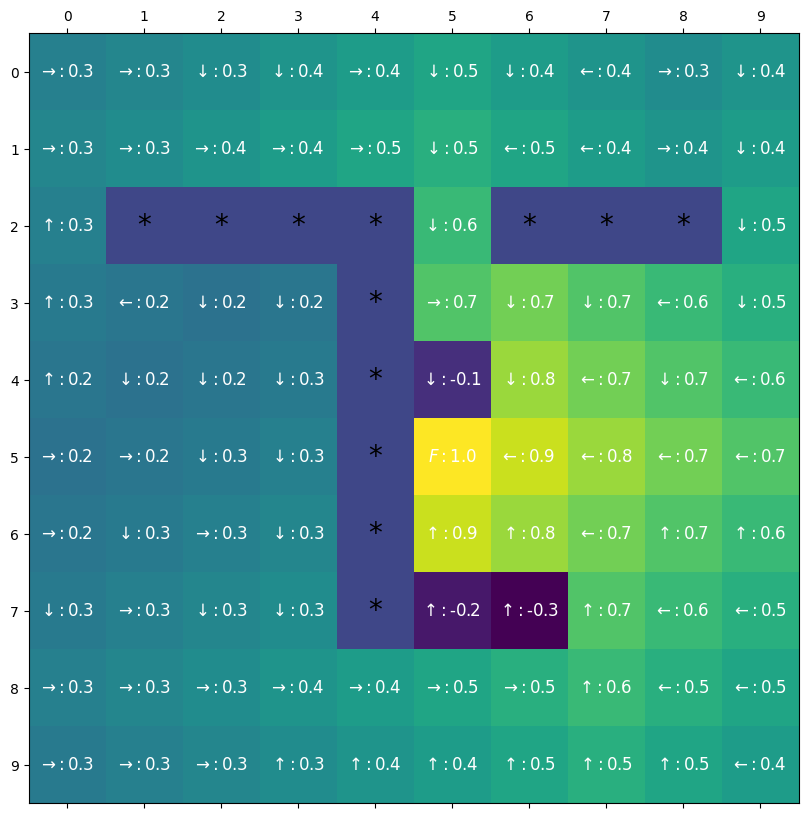

In [95]:
for i in range(100000):
  q_learning_agent.run_an_step()
q_learning_agent.plot_policy()

Con un alpha de 0.25, un descuento de 0.9 y más de 100 mil pasos de entrenamiento se observa como el algoritmo llega a una convergencia tanto de política como de Q valores. Se observa también como la política es óptima al llevar en la menor cantidad de pasos desde cualquier estado hasta la meta.

## Ejecución del método Q-Learning sobre Laberinto

In [96]:
board = [
  [' ',' ', '1',' ',' ','*',' ',' ',' ',' ',' '],
  [' ',' ', ' ',' ',' ','*',' ',' ',' ',' ',' '],
  [' ',' ', ' ',' ',' ',' ',' ',' ',' ',' ',' '],
  [' ',' ', ' ',' ',' ','*',' ',' ',' ',' ',' '],
  [' ',' ', ' ',' ',' ','*',' ',' ',' ',' ',' '],
  ['*','*', ' ','*','*','*','*','*',' ','*','*'],
  [' ',' ', ' ',' ',' ','*',' ',' ',' ',' ',' '],
  [' ',' ', ' ',' ',' ','*',' ',' ',' ',' ',' '],
  [' ',' ', ' ',' ',' ',' ',' ',' ',' ',' ',' '],
  [' ',' ', ' ',' ',' ','*',' ',' ',' ',' ',' '],
  [' ',' ', ' ',' ',' ','*',' ',' ',' ',' ',' '],
]

class Laberinto(GridWorld):
  def __init__(self):
    super().__init__(board)

In [114]:
q_learning_agent = Q_Learning(Laberinto)

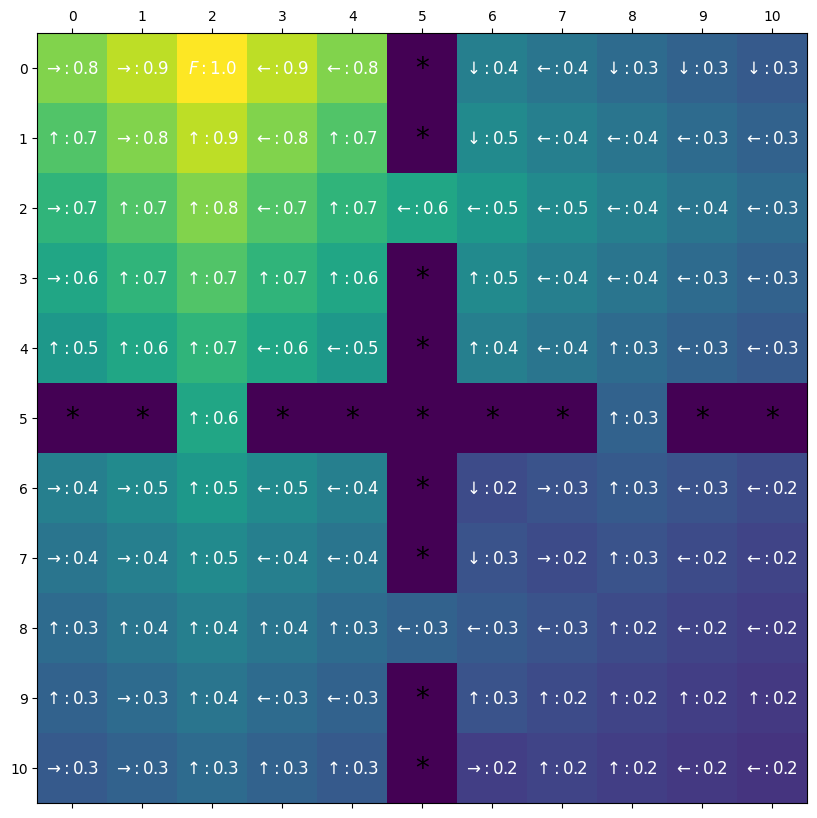

In [115]:
for i in range(400000):
  q_learning_agent.run_an_step()
q_learning_agent.plot_policy()

Con aproximadamente 400 mil pasos de entrenamiento puede notarse una convergencia de la política y de sus Q valores. Se observa como la política es óptima para cualquier estado del laberinto y como efectivamente llega a la salida desde que cualquier lugar del tablero.

## Ejecución del método Q-Learning sobre Taxi

In [135]:
board = [
  ['R',' ',' ',' ','G'],
  [' ',' ',' ',' ',' '],
  [' ',' ',' ',' ',' '],
  [' ',' ',' ',' ',' '],
  ['Y',' ',' ','B',' '],
]

class Taxi(GridWorld):
  def __init__(self):
    super().__init__(board)
    self.station_positions = [(0,0), (0,4), (4,0), (4,3)]
    self.current_state = (0,0, False)
    # Initialize a passanger in a random station
    # self.passenger_pos = random.choice(self.station_positions)
    self.passenger_pos = (0,0) # The passenger is in the red station always
    self.drop_station = None
    self.terminal_actions = ['D', 'P']

  def get_posible_actions(self, coordinates):
    if coordinates=='finished':
      return None
    
    return ['D', 'P','↑','↓','←','→']

  def get_reward(self, prev_state, new_state, action):
    new_pos = new_state[0:2]
    if new_pos == self.passenger_pos and action == 'P':
      self.passenger_pos = None
      # self.drop_station = random.choice([s for s in self.station_positions if s != new_pos])
      self.drop_station = (4,3) # The drop station is always the blue one
      return 1
    elif new_pos != self.passenger_pos and action == 'P':
      return -10 # Penalize the agent for picking up the passenger in the wrong place
    
    if new_pos == self.drop_station and action == 'D':
      self.drop_station = None
      # self.passenger_pos = random.choice(self.station_positions)
      self.passenger_pos = (0,0) # The passenger is in the red station always
      return 5
    elif new_pos != self.passenger_pos and action == 'D':
      return -10 # Penalize the agent for dropping the passenger in the wrong place
    
    return 0

  def is_valid_action(self, prev_state, state):
    is_valid = True
    # Add borders to the board that can't be crossed
    if prev_state[1] == 1 and (prev_state[0] == 0 or prev_state[0] == 1) and state[1] == 2 and (state[0] == 0 or state[0] == 1):
      is_valid = False
    if prev_state[1] == 2 and (prev_state[0] == 0 or prev_state[0] == 1) and state[1] == 1 and (state[0] == 0 or state[0] == 1):
      is_valid = False

    if prev_state[1] == 2 and (prev_state[0] == 3 or prev_state[0] == 4) and state[1] == 3 and (state[0] == 3 or state[0] == 4):
      is_valid = False
    if prev_state[1] == 3 and (prev_state[0] == 3 or prev_state[0] == 4) and state[1] == 2 and (state[0] == 3 or state[0] == 4):
      is_valid = False
    
    if prev_state[1] == 0 and (prev_state[0] == 3 or prev_state[0] == 4) and state[1] == 1 and (state[0] == 3 or state[0] == 4):
      is_valid = False
    if prev_state[1] == 1 and (prev_state[0] == 3 or prev_state[0] == 4) and state[1] == 0 and (state[0] == 3 or state[0] == 4):
      is_valid = False
    # The agent can't go beyond the board
    if state[0] < 0 or state[1] < 0:
      is_valid = False
    if state[0] > self.dimensions[0] -1 or state[1] > self.dimensions[1] -1:
      is_valid = False
    return  is_valid

  def do_action(self, action):
    curr_state = self.get_current_state()
    if curr_state == 'finished':
      return (0, 'finished')
    curr_row, curr_col, passenger_state =curr_state
    new_position = (curr_row, curr_col)

    # Get the new position
    if action == '↑':
       new_position = (curr_row-1, curr_col)
    elif action == '↓':
      new_position = (curr_row+1, curr_col)
    elif action == '←':
      new_position = (curr_row, curr_col-1)
    elif action == '→':
      new_position = (curr_row, curr_col+1)

    # Check if the new position is valid
    try:
      if not self.is_valid_action((curr_row, curr_col), new_position):
        new_position = (curr_row, curr_col)
    except:
      new_position = (curr_row, curr_col)

    # Update the passenger state
    if action == 'P' and  new_position == self.passenger_pos:
      passenger_state = True
    elif action == 'D' and new_position == self.drop_station:
      passenger_state = False

    # Calculate the reward as the current state reward
    try:
      reward = self.get_reward((curr_row, curr_col),new_position,action)
    except:
      reward = 0

    # When the finish action was sent set the state of the game as finished
    try:
      if self.is_terminal(new_position, passenger_state, action) and action in self.terminal_actions:
        new_position = 'finished'
        self.current_state = (new_position)
      else:
        self.current_state = (*new_position, passenger_state)
    except:
      print('error pos', new_position)

    return (reward, self.current_state)
  
  # The action is terminal if the agent is in terminal state or if the agenr dropped or picked up the passenger
  def is_terminal(self, state, is_passenger, action):
    if state == 'finished':
      return True
    curr_row, curr_col = state
    return self.board[curr_row][curr_col] in ['R','G','Y','B'] and ((not is_passenger and action == 'D') or (is_passenger and action == 'P'))
  
  # Reset the position in a random place but preserve the passenger state
  def reset(self):
    self.current_state = (random.randint(0, self.dimensions[0]-1),random.randint(0, self.dimensions[1]-1), bool(self.drop_station))

In [136]:
def show_values_on_the_board(agent, custom_state):
    state_values = copy.deepcopy(agent.env.board)
    for row in range(len(state_values)):
      for column in range(len(state_values[row])):
        state_values[row][column] = agent.get_value((row, column, custom_state), agent.get_action((row, column, custom_state)))
    return state_values

def plot_taxi_policy(agent):
  # Plot the policy
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  fig.suptitle('Taxi policy')
  state_per_plot = [False, True]
  for ax, custom_state in zip(axs.flat, state_per_plot):
    ax.matshow(show_values_on_the_board(agent, custom_state))
    rows = agent.env.dimensions[1]
    columns = agent.env.dimensions[0]
    ax.set_title(f'Passenger state: {custom_state}')
    ax.set_xticks(list(range(columns)))
    ax.set_yticks(list(range(rows)))
    states = [(i,j, custom_state) for j in range(columns) for i in range(rows)]
    for s in states:
      policy = None if agent.env.board[s[0]][s[1]] == '*' else agent.get_action(s)
      ax.annotate(f'${policy}: ${agent.get_value(s, policy):.1f}' if policy else '*', xy=(s[1], s[0]), xycoords='data', color='white' if policy else 'black',va='center', ha='center', fontsize=12 if policy else 20)
  plt.show()

In [139]:
q_learning_agent = Q_Learning(Taxi)

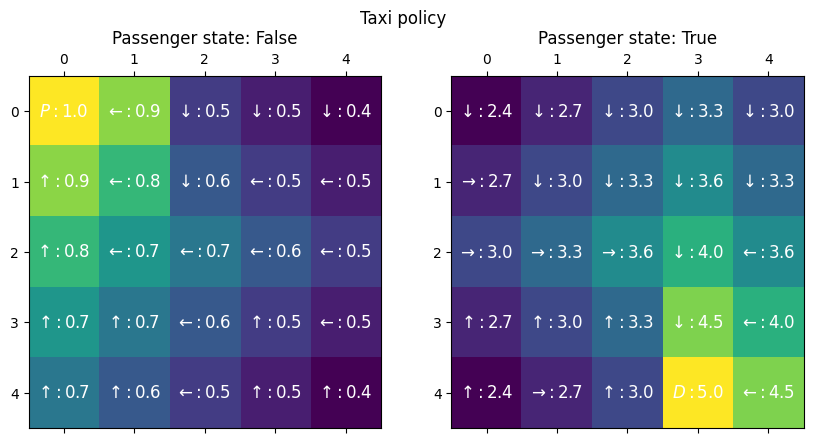

In [140]:
for i in range(200000):
  q_learning_agent.run_an_step()
plot_taxi_policy(q_learning_agent)

Fijando una posición donde aparece el pasajero y fijando la estación en la que debe ser dejado el algoritmo Q-learning logra aprender una política óptima con la que se cumplen los objetivos de dejar y recoger al pasajero en las estaciones respectivas y desde cualquier estado se logra el menor número de pasos posibles. El algoritmo se entrenó por 200 mil pasos, con un descuento de 0.9, un epsilon de 0.1 y un alpha de 0.25.